In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src import k_tree
from src.utils import data as dt
import torch
from src.k_tree import Ktree
from src.utils.data import loadData, loadData_3d
from src.metrics import Linf_simple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data, _ = loadData(10000)
# make data torch
if type(data) is not torch.Tensor:
    data = torch.tensor(data).to(device)
n = 100  # get randomly 5000 data
data = data[torch.randperm(data.size(0))[:n]]
# normalize data
x_min = data[:, 0].min().item()
x_max = data[:, 0].max().item()
y_min = data[:, 1].min().item()
y_max = data[:, 1].max().item()
l_max = data[:, 2].max().item()
bbox = torch.tensor(
    [
        x_min - l_max,
        x_max + l_max,
        y_min - l_max,
        y_max + l_max,
    ]
)
print(bbox)
# normalise data
data[:, 0] = (data[:, 0] - bbox[0]) / (bbox[1] - bbox[0])
data[:, 1] = (data[:, 1] - bbox[2]) / (bbox[3] - bbox[2])
data[:, 2] /= max(bbox[1] - bbox[0], bbox[3] - bbox[2])
# normalize data
x_min = data[:, 0].min().item()
x_max = data[:, 0].max().item()
y_min = data[:, 1].min().item()
y_max = data[:, 1].max().item()
l_max = data[:, 2].max().item()
bbox = torch.tensor(
    [
        x_min - l_max,
        x_max + l_max,
        y_min - l_max,
        y_max + l_max,
    ]
)
print(bbox)

Loading data...
Data loaded.
tensor([  70.7930, 6930.5049,   15.8503, 6839.1553])
tensor([5.8063e-11, 1.0000e+00, 3.1113e-06, 1.0000e+00])


In [6]:
import torch

# from src.k_tree_poly import Ktree as Ktree_pls
from src.k_tree_poly_copy import Ktree as Ktree
from src.utils.objects.squares import loadData as loadSquares
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dim = 2  # space dimension

k = 3  # number of centroids to generate in the Clustering model
clustering_args = {
    "epochs": 10,  # number of epochs
    "pre_processing": 10,
    "number_of_centroids": k,  # number of centroids to generate in the Clustering model
    "dimension": dim,  # space dimension
    "object_id": "squares",  # object id
}
# n = 50
n = 30
un_args = {
    "N": n,  # number of points to sample
    "M": n**2 - 1,  # number of points to return
    "epsilon": 0.2,  # the epsilon ball. Increase this to get more points (as var increases)
    # .15
}
critic_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 2000,  # number of epochs
    "width": 300,  # width of the model's linear layers
    "depth": 5,  # depth of the model's linear layers
}

# threshold = 100 - 1
threshold = 3 * k
# threshold = 998
threshold = 98

# Initialise the k-tree structure.
from src.metrics import Linf_simple

# pass data to the k-tree
distance_function = Linf_simple
ktree = Ktree(
    threshold,
    data,
    distance_function,
    clustering_args,
    un_args,
    critic_args,
    device,
    dim,
)
# pass data to device
# data = data.to(device)
print("Starting to create the tree...")
print("=" * 20)
# ktree.create_tree(save_path_prefix="./models/line_segments/2d/5k/", plot=False)
ktree.create_tree()

Starting to create the tree...

Creating critic for node 0 that has 100 data, which is more than the threshold 98.
Bounding box for node 0: [[5.806256116094172e-11, 1.0000000073850712], [3.111259026378449e-06, 0.9999968850386239]]
Creating clustering for node 0 with 3 centroids.
Initial divergence: 24.416868209838867
Starting iteration 1
Centroids:  tensor([[0.7412, 0.1533],
        [0.3237, 0.5692],
        [0.7649, 0.9134]], device='cuda:0')
Iteration 1, divergence: 0.24416868388652802
Starting iteration 2
Centroids:  tensor([[0.7226, 0.2265],
        [0.2843, 0.4471],
        [0.7728, 0.8045]], device='cuda:0')
Iteration 2, divergence: 0.21604713797569275
Starting iteration 3
Centroids:  tensor([[0.7510, 0.2473],
        [0.2282, 0.3344],
        [0.7041, 0.7950]], device='cuda:0')
Iteration 3, divergence: 0.19795028865337372
Starting iteration 4
Centroids:  tensor([[0.7813, 0.2682],
        [0.2232, 0.2883],
        [0.6733, 0.7936]], device='cuda:0')
Iteration 4, divergence: 0.195

KeyboardInterrupt: 

In [7]:
print(f"Tree node number is {ktree.number_of_nodes}")

leaves = ktree.get_leaves()

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)

Tree node number is 1
Tree height is 1.
Created 1 leaves with sizes
[100]


In [ ]:
acc.random_queries(ktree, 100, 1, 1)

KeyboardInterrupt: 

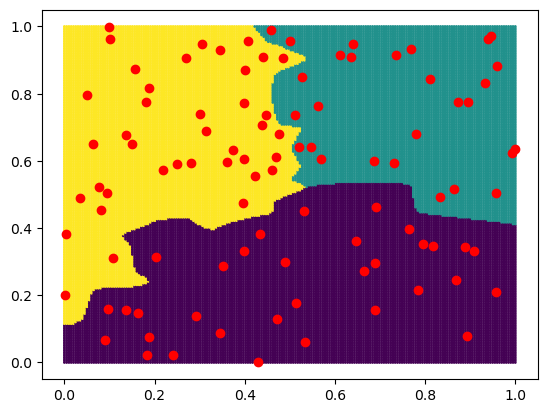

In [ ]:
n = 200
x = torch.linspace(0, 1, n)
y = torch.linspace(0, 1, n)
q = torch.stack(torch.meshgrid(x, y), dim=-1).reshape(-1, 2).to(device)

# pass
critic = ktree.root.critic
# critic = ktree.root.children[1].critic

# pass data to device
e = critic(q)
F, z = e.max(dim=1)

# plot the critic
fig, ax = plt.subplots()
ax.scatter(q[:, 0].cpu(), q[:, 1].cpu(), c=z.cpu(), s=1, cmap="viridis")
ax.scatter(data[:, 0].cpu(), data[:, 1].cpu(), c="red")
plt.show()